## 동전 이미지추출하기

In [1]:
#라이브러리 로딩
import cv2
import numpy as np

# 데이터 읽기
img = cv2.imread('data/coins_spread1.jpg')

# 그레이스케일 변환
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 노이즈 제거를 위한 가우시안 블러
blur=cv2.GaussianBlur(gray, (3,3), 0)

# 하프원 추출 (dp=1.5, minDist=30, cany_max=200)
circles = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT, 1.5, 30, None, 200)

if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0,:]:
        #원 둘레에 붉은색 원 그리기
        cv2.circle(img, (i[0], i[1]), i[2], (0,0,255), 2)
        
        #원 중심에 파란색 점 찍기
        cv2.circle(img, (i[0], i[1]), 2, (255, 0, 0), 5)

# 화면에 출력하기

cv2.imshow('Circles', img)
cv2.waitKey()
cv2.destroyAllWindows()

# 이진 영상 처리

## 영상의 이진화

* 영상의 픽셀 값을 0 또는 255(1)로 만드는 연산

    - 배경(background) vs 객체(object)
    
    - 관심 영역 vs. 비관심 영역 
    
    <img src="data/bi1.png" width= 500px>
    
    
    
* 그레이스케일 영상의 이진화

    <img src="data/bi2.png" width= 500px>
    

   
    
* 임계값 함수

```cv2.threshold(src,thresh,maxval,type,dst=None) -> retval,dst```

* 옵션

    - src : 입력 영상 . 다채널 , 8 비트 또는 32 비트 실수형
    - thresh: 사용자 지정 임계값
    - maxval 
        - cv2.THRESH_BINARY 또는 cv2.THRESH_BINARY_INV 방법 사용 시 최댓값
        - 보통 255 로 지정
    - type: cv2.THRESH_ 로 시작하는 플래그. 임계값 함수 동작 지정 또는 자동 임계값 결정 방법 지정
    - retval: 사용된 임계값
    - dst : 출력 영상 . src 와 동일 크기 , 동일 타입 , 같은 채널 수
 
 
 <img src="data/bi3.png" width= 700px> 

In [3]:
import sys
import numpy as np
import cv2


src = cv2.imread('data/leaves.jpg', cv2.IMREAD_GRAYSCALE)

if src is None:
    print('Image load failed!')
    sys.exit()

def on_threshold(pos):
    _,dst=cv2.threshold(src,pos,255,cv2.THRESH_BINARY)
    cv2.imshow('dst',dst)


cv2.imshow('src',src)
cv2.namedWindow('dst')
cv2.createTrackbar('Threshold','dst',0,255,on_threshold)
cv2.setTrackbarPos('Threshold','dst',4)
cv2.waitKey()
cv2.destroyAllWindows()

## 자동 이진화: Otsu 방법

* 임계값 자동 결정 방법

<img src="data/bi4.png" width=500px>


* Ostu 이진화 방법

    - 입력 영상이 배경(background)과 객체(object) 두 개로 구성되어 있다고 가정 -> Bimodal histogram
    - 임의의 임계값 T에 의해 나눠지는 두 픽셀 분포 그룹의 분산이 최소가 되는 T를 선택
    - 일종의 최적화 알고리즘 (optimization algorithm) 
    
 <img src="data/bi5.png" width=500px>   
 


 <img src="data/bi6.png" width=500px>   
 

 <img src="data/bi7.png" width=500px>   
 
 
 <img src="data/bi8.png" width=500px>   
 

In [7]:
import sys
import numpy as np
import cv2


src = cv2.imread('data/leaves.jpg', cv2.IMREAD_GRAYSCALE)

if src is None:
    print('Image load failed!')
    sys.exit()

th,dst=cv2.threshold(src,0,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)
print("otsu's threshold:",th)  #131

cv2.imshow('src',src)
cv2.imshow('dst',dst)
cv2.waitKey()
cv2.destroyAllWindows()

otsu's threshold: 103.0


## 지역 이진화

* 균영하지 않은 조명 환경에서 촬영된 영상의 이진화

 <img src="data/bi9.png" width=600px>
 
 
* 균일하지 않은 조명의 영향을 해결하려면?

    - 불균일한 조명 성분을 보상한 후 전역 이진화 수행 

 <img src="data/bi10.png" width=600px>
 
 
 
* 픽셀 주변에 작은 윈도우를 설정하여 지역 이진화 수행

    - 윈도우의 크기는?
    - 윈도우 형태는? uniform? Gaussian?
    - 윈도우를 겹칠 것인가? Overlap? Non-overlap?
    - 윈도우 안에 배경 또는 객체만 존재한다면?   
    
   <img src="data/bi11.png" width=600px>  
    

In [8]:
import sys
import numpy as np
import cv2


# 입력 영상 불러오기
src = cv2.imread('data/leaves.jpg', cv2.IMREAD_GRAYSCALE)

if src is None:
    print('Image load failed!')
    sys.exit()

#전역 이진화  by Otsu's method
_,dst1=cv2.threshold(src,0,255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)

#지역 이진화 by Otsu's method
dst2=np.zeros(src.shape,np.uint8)

bw=src.shape[1]//4
bh=src.shape[0]//4

for y in range(4):
    for x in range(4):
        src_=src[y*bh:(y+1)*bh,x*bw:(x+1)*bw]
        dst_=dst2[y*bh:(y+1)*bh,x*bw:(x+1)*bw]

        #-,dst_=으로 받으면 dst_는 출력으로만 받게됨으로 위에서 받은 부분영상 정보를 잊어버린다
        #그러므로 입력이자 출력으로 받기위해서 dst_를 인자로 주었다 
        # 대신 이렇게 사용하려면dst_는 src_와 크기가 꼭 같아야한다 그렇지않으면 정보를 잊어버린다
        cv2.threshold(src_,0,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU,dst_)
        ''' 디버깅용
        cv2.imshow('dst2',dst2)
        cv2.waitKey()
        cv2.destroyAllWindows()
        '''

# 결과 출력
cv2.imshow('src', src)
cv2.imshow('dst1', dst1)   #전역 이진화의 결과
cv2.imshow('dst2', dst2)   #지역 이진화의 결과
cv2.waitKey()
cv2.destroyAllWindows()


* OpenCV 적응형 이진화

```cv2.adaptiveThreshold(src,maxValue,adaptiveMethod,thresholdType,blockSize,c,dst=None) -> dst```

* 옵션

    - src: 입력 영상 . 그레이스케일 영상
    - maxValue: 임계값 함수 최댓값 . 보통 255.
    - adaptiveMethod: 블록 평균 계산 방법 지정 . cv2.ADAPTIVE_THRESH_MEAN_C 는 산술
    - 평균 , cv2.ADAPTIVE_THRESH_GAUSSIAN_C 는 가우시안 가중치 평균
    - thresholdType : cv2.THRESH_BINARY 또는 cv2.THRESH_BINARY_INV 지정
    - blockSize : 블록 크기 3 이상의 홀수
    - C: 블록 내 평균값 또는 블록 내 가중 평균값에서 뺄 값 .
      (x, y) 픽셀의 임계값으로 𝑇(𝑥,𝑦)=𝜇𝐵(𝑥,𝑦)−𝐶를 사용

In [10]:
import sys
import numpy as np
import cv2


src = cv2.imread('data/sudoku.jpg', cv2.IMREAD_GRAYSCALE)

if src is None:
    print('Image load failed!')
    sys.exit()


def on_trackbar(pos):
    bsize = pos               #blcokSize는 3의배수만 가능!
    if bsize % 2 == 0:
        bsize = bsize - 1
    if bsize < 3:
        bsize = 3

    dst = cv2.adaptiveThreshold(src, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY, bsize, 5)
    #블럭 안에 배경 혹은 객체만 있을경우 오동작을해 지저분한 형태로(점같은것) 나올수도 있다!
    #매 픽셀마다 블럭을 할당하고 결정하기 때문에 직접 구현한 지역 이진화 보다 느리다 
    cv2.imshow('dst', dst)

cv2.imshow('src', src)
cv2.namedWindow('dst')
cv2.createTrackbar('Block Size', 'dst', 0, 200, on_trackbar)
cv2.setTrackbarPos('Block Size', 'dst', 11)

cv2.waitKey()
cv2.destroyAllWindows()

## 모폴로지: 침식과 팽창

[모폴로지 연산]

* 영상을 형태학적인 측면에서 다루는 기법
* 다양한 영상 처리 시스템에서 전처리 또는 후처리 형태로 널리 사용
* 수학적 모폴로지


* 구조 요소(Structuring element)
    - 모폴로지 연산의 결과를 결정하는 커널, 마스크, 윈도우
    <img src="data/mo1.png" width=500px>
    
    
    
* 이진 영상의 침식(errosion) 연산
    - 구조 요소가 객체 영역 내부에 완전히 포함될 경우 고정점 픽셀을 255로 설정
    - 침식 연산은 객체 외각을 깍아내는 연산 --> 객체 크기는 감소 & 배경은 확대
       <img src="data/mo2.png" width=500px>
 
 
 
* 이진 영상의 팽창(diliation) 연산
    - 구조 요소와 객체 영역이 한 픽셀이라도 만날 경우 고정점 픽셀을 255로 설정
    - 팽창 연산은 객체 외곽을 확대시키는 연산 -> 객체 크기는 감소 & 배경은 확대
       <img src="data/mo3.png" width=500px>
    
    
    
* 실제 영상의 침식 연산 결과
    - 객체 영역(흰색)이 점점 줄어듦
    - 작은 크기의 객체(잡음) 제거 효과       
       <img src="data/mo4.png" width=500px>    




* 실제 영상의 팽창 연산 결과
    - 객체 영역(흰색)이 점점 늘어남
    - 객체 내부의 홈(구멍)이 채워짐
       <img src="data/mo5.png" width=500px> 
   
   
   
       
* 모폴로지 침식 연산

```cv2.erode(src,kernel,dst=None,anchor=None,iteration=None,borderType=None,borderValue=None)```



* 옵션의미

    - src: 입력 영상
    - kernel: 
        - 구조 요소 . getStructuringElement () 함수에 의해 생성 가능
        - 만약 None 을 지정하면 3x3 사각형 구성 요소를 사용
    - dst : 출력 영상 . src 와 동일한 크기와 타입
    - anchor: 고정점 위치 . 기본값(-1, -1) 을 사용하면 중앙점을 사용
    - iterations: 반복 횟수 . 기본값은 1.
    - borderType: 가장자리 픽셀 확장 방식 . 기본값은 cv2.BORDER_CONSTANT.
    - borderValue: cv2.BORDER_CONSTANT 인 경우 , 확장된 가장자리 픽셀을 채울 값
    
* 모폴로지 팽창 연산

```cv2.dilate(src,kernel,dst=None,anchor=None,iteration=None,borderType=None,borderValue=None)```


* 옵션의미
    - src: 입력 영상
    - kernel: 
        - 구조 요소 . getStructuringElement () 함수에 의해 생성 가능
        - 만약 None 을 지정하면 3x3 사각형 구성 요소를 사용
    - dst : 출력 영상 . src 와 동일한 크기와 타입
    - anchor: 고정점 위치 . 기본값(-1, -1) 을 사용하면 중앙점을 사용
    - iterations: 반복 횟수 . 기본값은 1.
    - borderType: 가장자리 픽셀 확장 방식 . 기본값은 cv2.BORDER_CONSTANT.
    - borderValue: cv2.BORDER_CONSTANT 인 경우 , 확장된 가장자리 픽셀을 채울 값
 
 
 
 
*  모폴로지 구조 요소 (커널) 생성


``` cv2.getStructuringElement(shape,ksize,anchor=None)```


 
   <img src="data/mo6.png" width=500px>

[이진 이미지의 침식과 팽창 예제]

In [1]:
import sys
import numpy as np
import cv2


src = cv2.imread('data/leaves.jpg', cv2.IMREAD_GRAYSCALE)

if src is None:
    print('Image load failed!')
    sys.exit()

se=cv2.getStructuringElement(cv2.MORPH_RECT,(5,3))  #행렬 크기조정을 통해 끊어진 부분을 연결시키거나 할 수 있다

dst1=cv2.erode(src,se)
dst2=cv2.dilate(src,None)     #단순 3x3행렬 kernel

cv2.imshow('src',src)
cv2.imshow('dst1',dst1)
cv2.imshow('dst2',dst2)
cv2.waitKey()
cv2.destroyAllWindows()

## 모폴로지: 열기와 닫기

* 이진 영상의 열기연산

    <img src="data/mo7.png" width=300px>
    


* 이진 영상의 열기연산

    <img src="data/mo8.png" width=300px>
    
    


    <img src="data/mo9.png" width=500px>
    
    
* 범용 모폴로지 연산 함수

```cv2.morphologyEx(src,op,kernel,dst=None,anchor=None,iteration=None,borderType=None,borderValue=None)```


   <img src="data/mo10.png" width=600px>

[열기 연산을 이용한 잡음 제거]

In [2]:
import sys
import numpy as np
import cv2


src = cv2.imread('data/leaves.jpg', cv2.IMREAD_GRAYSCALE)

if src is None:
    print('Image load failed!')
    sys.exit()

#src영상에 지역 이진화 수행(local_th.py참고(지역이진화 구현 부분))

dst1=np.zeros(src.shape,np.uint8)

bw=src.shape[1] // 4
bh=src.shape[0] // 4

for y in range(4):
    for x in range(4):
        src_=src[y*bh : (y+1)*bh, x*bw : (x+1)*bw]
        dst_=dst1[y*bh : (y+1)*bh, x*bw : (x+1)*bw]
        cv2.threshold(src_,0,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU,dst_)

cnt1,_=cv2.connectedComponents(dst1)   #영상 안에 있는 흰색 덩어리들의 개수를 return 해준다  
                                       #노이즈가 정확한 갯수를 세는것을 방해한다
print('cnt1:',cnt1)

dst2=cv2.morphologyEx(dst1,cv2.MORPH_OPEN,None)
#dst2=cv2.erode(dst1,None)
#dst2=cv2.dilate(dst2,None)   #수동으로 침식-> 열기 수행 실제로 위 함수도 옆과 같은 두단계로 이루어져 있다

cnt2,_=cv2.connectedComponents(dst2)
print('cnt2:',cnt2)

cv2.imshow('src',src)
cv2.imshow('dst1',dst1)
cv2.imshow('dst2',dst2)
cv2.waitKey()
cv2.destroyAllWindows()

cnt1: 1539
cnt2: 266


# 레이블링

* 객체 단위 분석

    - (흰색) 객체를 분할하여 특징을 분석
    - 객체 위치 및 크기 정보, ROI추출, 모양 분석 등


  <img src="data/out1.png" width=300px>

    
    
    
* 레이블링(Connected Component Labeling)

    - 서로 연결되어 있는 객체 픽셀에 고유한 번호를 지정(레이블맵)
    - 영역 기반 모양 분석
    - 레이블맵, 바운딩 박스 ,픽셀 개수, 무게 중심 좌표를 반환
    
    <img src="data/out2.png" width=300px>    
    
   
   
* 외곽선 검출(Contour Tracing)

    - 각 객체의 외곽선 좌표를 모두 검출
    - 외곽선 기반 모양 분석
    - 다양한 외곽선 처리 함수에서 활용 가능(근사화, 컨벡스힐 등)
    
    <img src="data/out3.png" width=300px>       
    
  
  
* 레이블링 이란?
 
     - 동일 객체에 속한 모든 픽셀에 고유한 번호를 매기는 작업
     - 일반적으로 이진 영상에서 수행
     - Connected component labeling



* 픽셀의 연결 관계

    - 4-이웃 연결 관계
    - 8-이웃 연결 관계   
    
        <img src="data/out4.png" width=500px> 
        
        
* 레이블링 알고리즘의 입력과 출력

     <img src="data/out5.png" width=500px> 
     
     
     
* 레이블링 함수

```cv2.connectedComponents(image,label=None,connectivity=None,Itype=None) -> retval,labels```

* 옵션
     - image: 8 비트 1 채널 영상
     - labels: 레이블 맵 행렬 . 입력 영상과 같은 크기 . numpy.ndarray
     - connectivity: 4 또는 8. 기본값은 8.
     - ltype : labels 타입 . cv2.CV_32S 또는 cv2.CV_16S. 기본값은 cv2.CV_32S.
     - retval: 객체 개수 . 
         - N 을 반환하면 [0, N-1] 의 레이블이 존재
         - 0 은 배경을 의미 (실제 흰색 객체 개수는 N-1개) 
         
         
* 객체 정보를 함께 반환하는 레이블링 함수

```cv2.connectedComponentsWithStats(image,labels=None,stats=None,centroids=None,connectivity=None,Itype=None) -> retval,labels,stats,centroids ``` 
                      
        
* 옵션

    - image: 8 비트 1 채널 영상
    - labels: 레이블 맵 행렬 . 입력 영상과 같은 크기 . numpy.ndarray
    - stats: 각 객체의 바운딩 박스 
        - 픽셀 개수 정보를 담은 행렬 numpy.ndarray 
        - shape=shape=(N, 5)
        - dtype numpy.int32
    - centroids: 각 객체의 무게 중심 위치 정보를 담은 행렬. numpy.ndarray
        - shape=shape=(N, 2)
        - dtype numpy.float64
    - ltype : labels 행렬 타입 . cv2.CV_32S 또는 cv2.CV_16S. 기본값은 cv2.CV_32S.



 <img src="data/out6.png" width=600px> 

[키보드 이미지에서 문자 영역을 라벨링 예제]

In [ ]:
import sys
import numpy as np
import cv2

src=cv2.imread('keyboard.bmp',cv2.IMREAD_GRAYSCALE)

if src is None:
    print('Image load failed!')
    sys.exit()

#이진화된 영상
_,src_bin=cv2.threshold(src,0,255,cv2.THRESH_BINARY |cv2.THRESH_OTSU)  #otsu 만 써도 잘 동작함
# src_bin2=cv2.morphologyEx(src_bin,cv2.MORPH_OPEN,None) opening 방법으로 노이즈 제거

cnt,labels,stats,centroids=cv2.connectedComponentsWithStats(src_bin)

dst=cv2.cvtColor(src,cv2.COLOR_GRAY2BGR)
#객체 위치에 빨간색 사각형 형성
for i in range(1,cnt):   #배경은 필요 없으므로 1부터 시작
    x,y,w,h,a=stats[i]

    if a<20:            #면적이 작은 객체들은 사각형 형성하지 않는다 오프닝 방법보다 시간이 덜 걸릴듯
        continue

    cv2.rectangle(dst,(x,y,w,h),(0,0,255),2)

cv2.imshow('src',src)
cv2.imshow('src_bin',src_bin)
cv2.imshow('dst',dst)
cv2.waitKey()
cv2.destroyAllWindows()

# 외곽선 검출

* 외곽선 검출

    - 객체의 외곽선 좌표를 모두 추출하는 작업. Boundary tracking. Contour tracing.
    - 바깥쪽 & 안쪽(홀) 외곽선 -> 외곽선의 계층 구조도 표현 가능
 

* 외곽선 객체 하나의 표현 방법
   
    - numpy.ndarray
    - shape=(K,1,2) (K는 외곽선 좌표 개수)
    - dtype=numpy.int32
 

* 여러 외곽선 표현 방법
    
    - "객체 하나의 외곽선(numpy.ndarray)"을 원소로 갖는 리스트
    - len(리스트)=전체 외곽선 개수(N)
 

* 외곽선 검출 함수

```cv2.findContours(image,mode,method,contours=None,hierarchy=None,offset=None) -> contours,hierachy```

* 옵션

     - image: 입력 영상 . non zero 픽셀을 객체로 간주함
     - mode: 외곽선 검출 모드 . cv2.RETR_ 로 시작하는 상수
     - method: 외곽선 근사화 방법 . cv2.CHAIN_APPROX_ 로 시작하는 상수
     - contours: 검출된 외곽선 좌표 . numpy.ndarray 로 구성된 리스트
         - len (contours)= 전체 외곽선 개수 (N)
         - contours[ i ]. shape=(K, 1, 2). contours[i].dtype=numpy.int32
     - hierarchy: 외곽선 계층 정보 . numpy.ndarray.shape=(1,N,4). dtype numpy.int32
         - hierarchy[0,i ,0] ~ hierarchy[0,i,3] 이 순서대로 next, prev , child, parent
         - 외곽선 인덱스를 가리킴 . 해당 외곽선이 없으면 -1.
     - offset:  좌표 값 이동 옵셋 . 기본값은 (0,0)
     
   <img src="data/out7.png" width=300px>
   
   <img src="data/out8.png" width=500px>
   
   <img src="data/out9.png" width=500px> 
   
   
* 외곽선 그리기

```cv2.drawContours(image,contours,contourIdx,color,thickness=None,LineType=None,hirarchy=None,maxLevel=None,offset=None) -> image```

* 옵션

    - image: 입출력 영상
    - contours:contours: (cv2.findContours() 함수로 구한) 외곽선 좌표 정보
    - contourIdx: 외곽선 인덱스 . 음수 (-1) 를 지정하면 모든 외곽선을 그린다
    - color: 외곽선 색상
    - thickness: 외곽선 두께 . thinkness < 0 이면 내부를 채운다
    - lineType : LINE_4, LINE_8, LINE_AA 중 하나 지정
    - hierarchy: 외곽선 계층 정보
    - maxLevel : 그리기를 수행할 최대 외곽선 레벨 . 
        - maxLevel = 0 이면 contourIdx 로 지정된 외곽선만 그린다

In [11]:
import sys
import random
import numpy as np
import cv2


src = cv2.imread('data/contours.bmp', cv2.IMREAD_GRAYSCALE)

if src is None:
    print('Image load failed!')
    sys.exit()


contours,hier=cv2.findContours(src,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_NONE)
dst=cv2.cvtColor(src,cv2.COLOR_GRAY2BGR)

idx=0
while idx>=0:
    c=(random.randint(0,255),random.randint(0,255),random.randint(0,255))
    cv2.drawContours(dst,contours,idx,c,2,cv2.LINE_8,hier)   
    #hier 는 외각선 계층 정보로 이것을 지우면 제일 바깥부분만 색이 칠해진다
    #그런데 findContours에서 cv2.RETR_LIST를 사용하면 계층정보가 없으므로 hier인자가 있든 없든 상관이 없다
    idx=hier[0,idx,0]      #hier[0,i,0]~hier[0,i,3]이 순서대로 next,prev,child,parent
    
cv2.imshow('src',src)
cv2.imshow('dst',dst)
cv2.waitKey()
cv2.destroyAllWindows()

In [12]:
import sys
import random
import numpy as np
import cv2


src = cv2.imread('data/milkdrop.bmp', cv2.IMREAD_GRAYSCALE)

if src is None:
    print('Image load failed!')
    sys.exit()
_,src_bin=cv2.threshold(src,0,255,cv2.THRESH_OTSU)

contours,_=cv2.findContours(src_bin,cv2.RETR_LIST,cv2.CHAIN_APPROX_NONE)
#list 로 받았기 때문에 hier받을 필요 없음
#contours의 길이가 외각선 객체의 갯수가 된다

h,w=src.shape[:2]
dst=np.zeros((h,w,3),np.uint8)

for i in range(len(contours)):
    c=(random.randint(0,255),random.randint(0,255),random.randint(0,255))
    cv2.drawContours(dst,contours,i,c,1,cv2.LINE_AA)
    

cv2.imshow('src', src)
cv2.imshow('src_bin', src_bin)
cv2.imshow('dst', dst)
cv2.waitKey()
cv2.destroyAllWindows()

## 다양한 외곽선 함수

* 다른 외곽선 관련 함수들

<img src="data/out11.png" width=500px>


* 외곽선 길이 구하기

```cv2.arcLength(curve,closed) -> retval```

* 옵션

    - curve: 외곽선 좌표 . numpy.ndarray . shape=(K, 1, 2)
    - closed: True 이면 폐곡선으로 간주 
    - retval: 외곽선 길이
    
* 면적 구하기

```cv2.contourArea(contour,oriented=None) -> retval```

* 옵션

    - contour: 외곽선 좌표 . numpy.ndarray . shape=(K, 1, 2)
    - oriented: True 이면 외곽선 진행 방향에 따라 부호 있는 면적을 반환 기본값은 False
    - retval: 외곽선으로 구성된 영역의 면적
    
* 바운딩 박스(외곽선을 외접하여 둘러싸는 가장 작은 사각형) 구하기

```cv2.boundingRect(array) -> retval```

* 옵션

    - array: 외곽선 좌표 . numpy.ndarray . shape=(K, 1, 2)
    - retval: 사각형 정보 . (x, y, w, h) 튜플
    
* 바운딩 서클(외곽선을 외접하여 둘러싸는 가장 작은 원) 구하기

```cv2.minEnclosingCircle(points) -> center,radius```

* 옵션

    - points: 외곽선 좌표 . numpy.ndarray.shape=(K, 1, 2)
    - center: 바운딩 서클 중심 좌표. (x, y) 튜플
    - radius: 바운딩 서클 반지름. 실수
    
* 외곽선 근사화

```cv2.approxPolyDP(curve,epsilon,closed,approxCurve=None) -> approxCurve```

* 옵션

    - curve: 입력 곡선 좌표. numpy.ndarray. shape=(K, 1, 2)
    - epsilon: 근사화 정밀도 조절. 입력 곡선과 근사화 곡선 간의 최대 거리.
               e.g) cv2.arcLength(curve) * 0.02
    - closed: True를 전달하면 폐곡선으로 인식
    - approxCurve: 근사화된 곡선 좌표. numpy.ndarray. shape=(K', 1, 2)
    
<img src="data/out12.png" width=500px>
    
* Convex 검사

``` cv2.isContourConvex(contour) -> retval```

* 옵션

    - contour: 입력 곡선 좌표 . numpy.ndarray . shape=(K, 1, 2)
    - retval 컨벡스이면 True, 아니면 False.
    
    <img src="data/out13.png" width=500px>
    
    
* 다각형 검출 프로그램

    - 다양한 다각형 객체 영상에서 삼각형, 사각형, 원 찾기
    
    
* 구현 순서

    1) 이진화
    2) 외곽선 찾기
    3) 외곽선 근사화
    4) 너무 작은 객체와 컥벡스가 아닌 객체 제외
    5) 꼭지점 개수 확인
    
        1) 삼각형, 사각형 검출
        2) 원 판별
        
     <img src="data/out14.png" width=400px>      
     

 <img src="data/out15.png" width=600px>      

In [13]:
import math
import cv2

def setLabel(img,pts,label):
    (x,y,w,h)=cv2.boundingRect(pts)
    pt1=(x,y)
    pt2=(x+w,y+h)
    cv2.rectangle(img,pt1,pt2,(0,0,255),1)
    cv2.putText(img,label,pt1,cv2.FONT_HERSHEY_PLAIN,1,(0,0,255))



def main():
    img=cv2.imread('data/polygon.bmp',cv2.IMREAD_COLOR)

    if img is None:
        print('image load failed!')
        return
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    _,img_bin=cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    #도형들이 배경보다 밝은 사진이기 때문에 INV를 해주어야 한다
    contours,_=cv2.findContours(img_bin,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    # EXTERNAL을 통해 바깥쪽에 있는 것만 검출
    
    for pts in contours:
        if cv2.contourArea(pts)<400:   #너무 작으면 무시
            continue

        approx=cv2.approxPolyDP(pts,cv2.arcLength(pts,True)*0.02,True)  #외곽선 근사화
        vtc=len(approx)

        if vtc==3:
            setLabel(img,pts,'TRI')
        elif vtc==4:
            setLabel(img,pts,'RECT')
        elif vtc==10:
            setLabel(img,pts,'STAR')
        else:
            length=cv2.arcLength(pts,True)
            area=cv2.contourArea(pts)
            ratio=4.*math.pi*area/(length*length)

            if ratio>0.85:
                setLabel(img,pts,'CIR')
            elif 0.70<ratio<0.85:
                setLabel(img,pts,'ELLIPSE')
            else:
                setLabel(img,pts,'POLY')

    cv2.imshow('img',img)
    cv2.waitKey()
    cv2.destroyAllWindows()

if __name__ == '__main__':
    main()

## [실습] 번호판 인식기

[할 일]

1. 사진에서 자동차 번호판 부분에 라벨링
2. 번호판의 글자 인식하기


[사용기술]
1.


[사용할 라이브러리]

cv2, numpy, matplotlib, pytesseract(이미지에서 글씨를 읽어내는 라이브러리)

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
plt.style.use('dark_background')

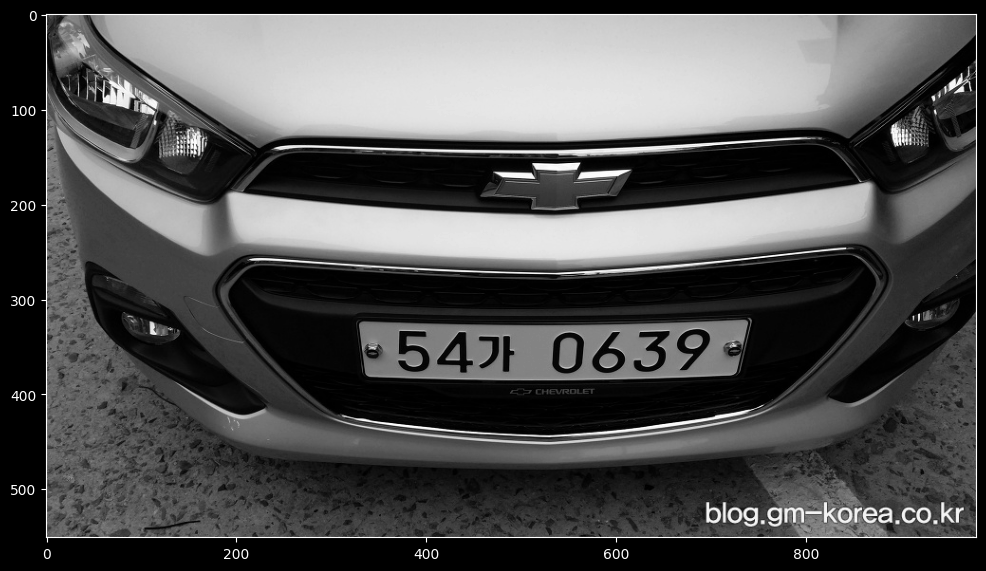

In [6]:
img_ori = cv2.imread('data/num_3.jpg')
gray = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY)

height, width, channel = img_ori.shape

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')

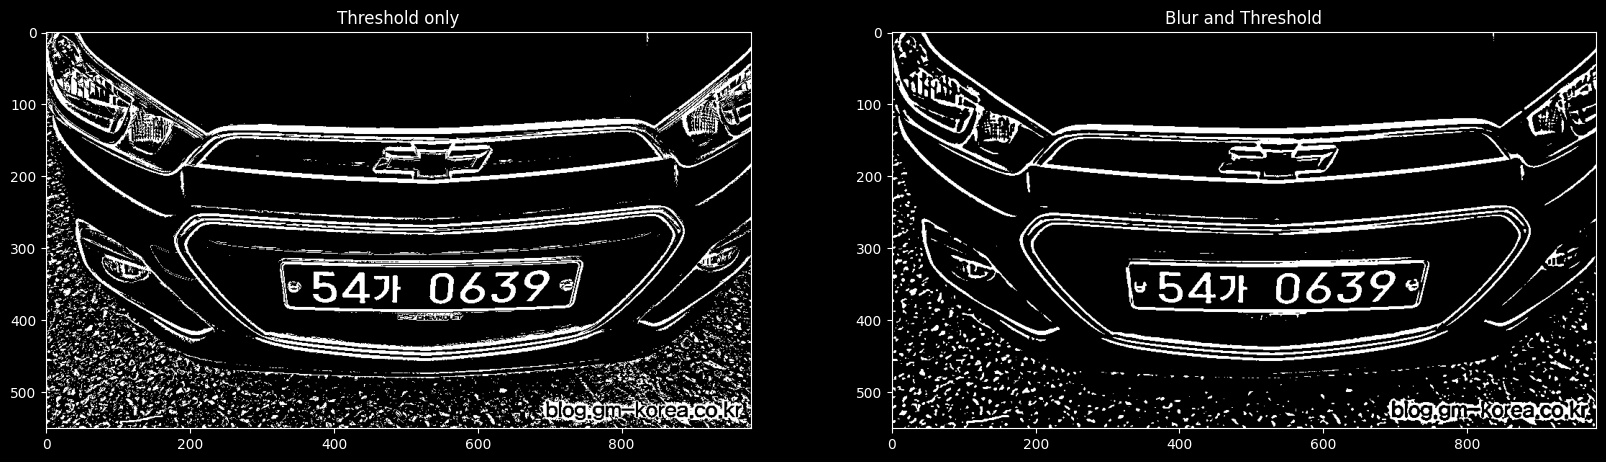

In [7]:
# threshold only
img_thresh = cv2.adaptiveThreshold(
    gray, 
    maxValue=255.0, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=19, 
    C=9
)

# blur and threshold
img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)

img_blur_thresh = cv2.adaptiveThreshold(
    img_blurred, 
    maxValue=255.0, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=19, 
    C=9
)

plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.title('Threshold only')
plt.imshow(img_thresh, cmap='gray')
plt.subplot(1, 2, 2)
plt.title('Blur and Threshold')
plt.imshow(img_blur_thresh, cmap='gray')

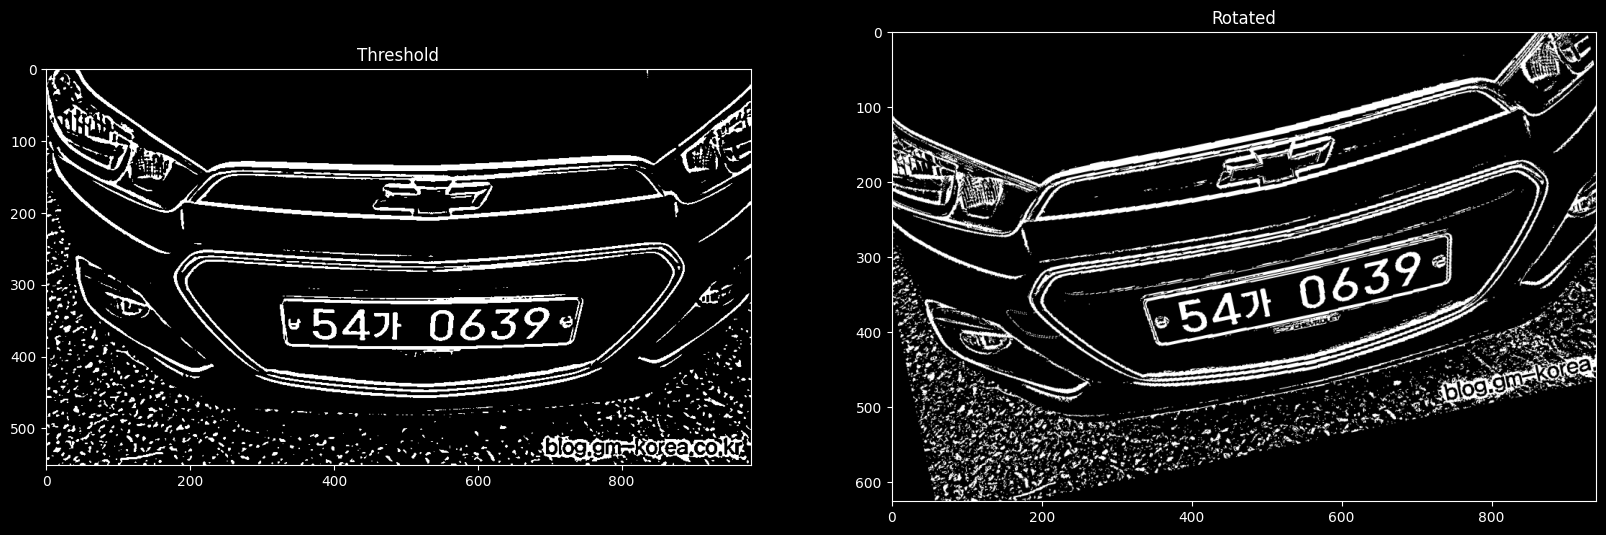

In [8]:
plate_cx, plate_cy = 508.75, 300.5
width, height = 940, 626 
plate_width, plate_height = 188.5, 49
angle = 11.9565

rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)
img_rotated = cv2.warpAffine(img_thresh, M=rotation_matrix, dsize=(width, height))

plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.title('Threshold')
plt.imshow(img_blur_thresh, cmap='gray')
plt.subplot(1, 2, 2)
plt.title('Rotated')
plt.imshow(img_rotated, cmap='gray')

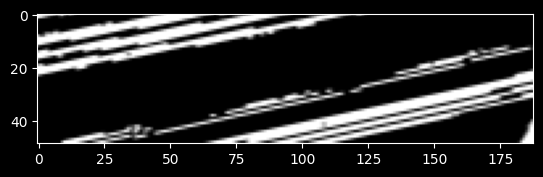

In [10]:
img_cropped = cv2.getRectSubPix(
    img_rotated, 
    patchSize=(int(plate_width), int(plate_height)), 
    center=(int(plate_cx), int(plate_cy))
)

plt.imshow(img_cropped, cmap='gray')